In [34]:
import maxvol
import numpy as np

a = np.random.random((10000, 20))

In [13]:
a

array([[0.45320358, 0.22101824, 0.31889719, 0.22032821, 0.03169154],
       [0.46176343, 0.44780515, 0.62500799, 0.38231652, 0.48254906],
       [0.66095195, 0.36196882, 0.42622421, 0.23625767, 0.70043418],
       [0.63415113, 0.54360409, 0.81308563, 0.04222683, 0.4564395 ],
       [0.01382311, 0.94345952, 0.46434485, 0.55402038, 0.1613438 ],
       [0.75093095, 0.46563868, 0.38091198, 0.29704076, 0.41437154],
       [0.64976639, 0.17458607, 0.033256  , 0.37539687, 0.98089134],
       [0.96096007, 0.13057112, 0.32154663, 0.66940468, 0.52479931],
       [0.06032283, 0.90399171, 0.41352252, 0.16694164, 0.07628158],
       [0.65938295, 0.68140426, 0.84358318, 0.5786835 , 0.01432325],
       [0.50119048, 0.6896107 , 0.45820363, 0.20519645, 0.62350852],
       [0.83096134, 0.12780229, 0.35744339, 0.70200937, 0.91759606],
       [0.29410593, 0.42152393, 0.5613586 , 0.41553113, 0.70229   ],
       [0.41708508, 0.63586911, 0.08272672, 0.19843965, 0.45427048],
       [0.86025353, 0.66907582, 0.

In [35]:
upper_rows, lower_rows = maxvol.maxvol(a, np.random.permutation(a.shape[0])[:a.shape[1]])

In [36]:
abs(np.linalg.det(a[upper_rows]))

816.4895201585615

In [31]:
import itertools

vols = np.stack([abs(np.linalg.det(a[list(rows)])) for rows in itertools.combinations(range(50), 5)])

(array([1.831288e+06, 2.213320e+05, 4.842000e+04, 1.255500e+04,
        3.636000e+03, 1.043000e+03, 3.230000e+02, 1.100000e+02,
        3.900000e+01, 1.400000e+01]),
 array([4.03155144e-09, 1.04268584e-01, 2.08537163e-01, 3.12805743e-01,
        4.17074323e-01, 5.21342903e-01, 6.25611482e-01, 7.29880062e-01,
        8.34148642e-01, 9.38417221e-01, 1.04268580e+00]),
 <BarContainer object of 10 artists>)

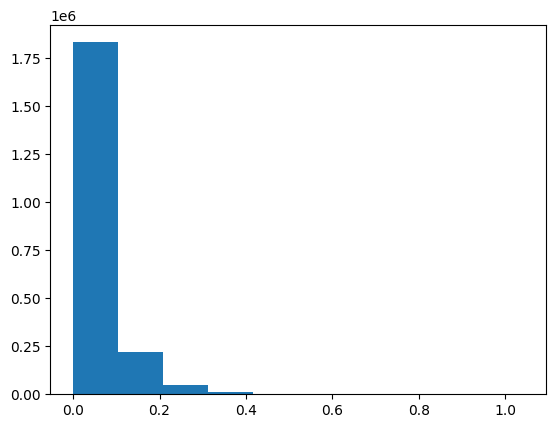

In [32]:
import matplotlib.pyplot as plt

plt.hist(vols)